In [32]:
%matplotlib inline

## Task 1


# Compare Stochastic learning strategies for MLPClassifier

This example visualizes some training loss curves for different stochastic
learning strategies, including SGD and Adam. Because of time-constraints, we
use several small datasets, for which L-BFGS might be more suitable. The
general trend shown in these examples seems to carry over to larger datasets,
however.

Note that those results can be highly dependent on the value of
``learning_rate_init``.



learning on dataset iris
training: constant learning-rate
Training set score: 0.980000
Training set loss: 0.096950
training: constant with momentum
Training set score: 0.980000
Training set loss: 0.049530
training: constant with Nesterov's momentum
Training set score: 0.980000
Training set loss: 0.049540
training: inv-scaling learning-rate
Training set score: 0.360000
Training set loss: 0.978444
training: inv-scaling with momentum
Training set score: 0.860000
Training set loss: 0.503452
training: inv-scaling with Nesterov's momentum
Training set score: 0.860000
Training set loss: 0.504185
training: adam
Training set score: 0.980000
Training set loss: 0.045311

learning on dataset digits
training: constant learning-rate
Training set score: 0.956038
Training set loss: 0.243802
training: constant with momentum
Training set score: 0.992766
Training set loss: 0.041297
training: constant with Nesterov's momentum
Training set score: 0.993879
Training set loss: 0.042898
training: inv-scaling 

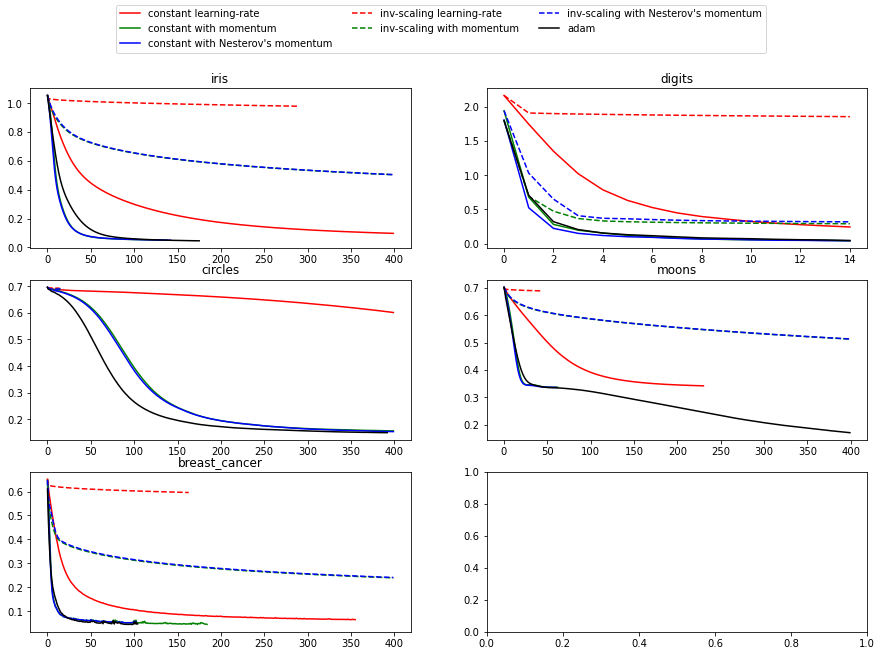

In [33]:
# Modified: Jing Zhan

import warnings

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

labels = [
    "constant learning-rate",
    "constant with momentum",
    "constant with Nesterov's momentum",
    "inv-scaling learning-rate",
    "inv-scaling with momentum",
    "inv-scaling with Nesterov's momentum",
    "adam",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)

    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            mlp.fit(X, y)

        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(3, 2, figsize=(15, 10))
# load / generate some toy datasets
iris = datasets.load_iris()
breast_cancer=datasets.load_breast_cancer()
X_digits, y_digits = datasets.load_digits(return_X_y=True)
data_sets = [
    (iris.data, iris.target),
    (X_digits, y_digits),
    datasets.make_circles(noise=0.2, factor=0.5, random_state=1),
    datasets.make_moons(noise=0.3, random_state=0),(breast_cancer.data, breast_cancer.target),
]

for ax, data, name in zip(
    axes.ravel(), data_sets, ["iris", "digits", "circles", "moons","breast_cancer"]
):
    plot_on_dataset(*data, ax=ax, name=name)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

##### For the breast_cancer, the momentums help to reduce the error, that it is, the constant with momentum is better than the constant learning-rate; 

##### the inv-scaling is worse than constant learning rate, especially the inv-scaling learning-rate without momentum;

##### the optimization solvers Adam helps to get the lowest error as the constant with momentum

## Task 2

### Varying regularization in Multi-layer Perceptron

##### A comparison of different values for regularization parameter 'alpha' on synthetic datasets. The plot shows that different alphas yield different decision functions.

##### Alpha is a parameter for regularization term, aka penalty term, that combats overfitting by constraining the size of the weights. Increasing alpha may fix high variance (a sign of overfitting) by encouraging smaller weights, resulting in a decision boundary plot that appears with lesser curvatures. Similarly, decreasing alpha may fix high bias (a sign of underfitting) by encouraging larger weights, potentially resulting in a more complicated decision boundary.

In [34]:
%matplotlib inline

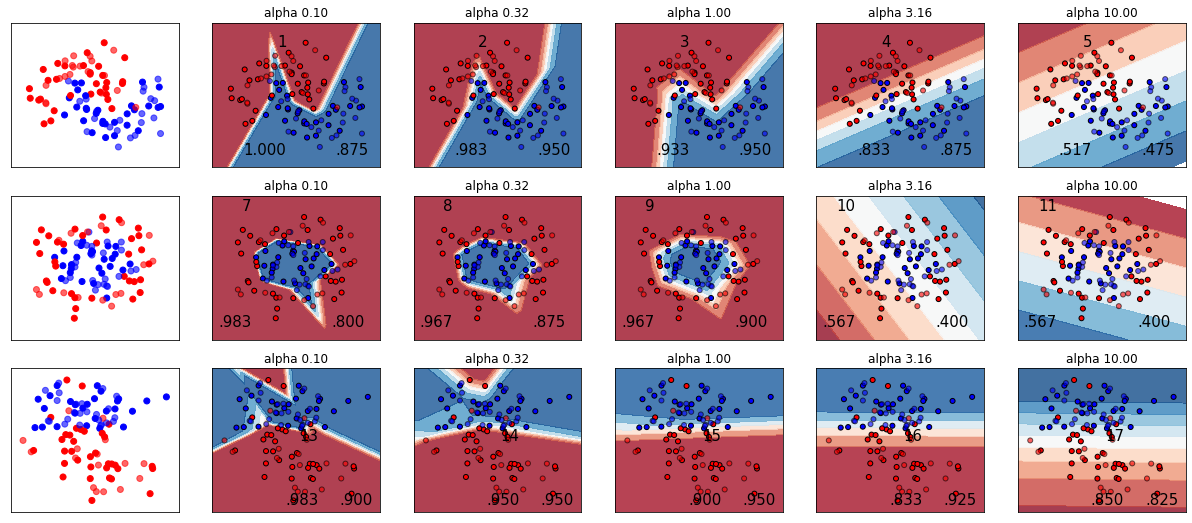

In [35]:
# Author: Issam H. Laradji 
# Modified: Jing Zhan
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

h = 0.02  # step size in the mesh

alphas = np.logspace(-1, 1, 5)

classifiers = []
names = []
for alpha in alphas:
    classifiers.append(
        make_pipeline(
            StandardScaler(),
            MLPClassifier(
                solver="lbfgs",
                alpha=alpha,
                random_state=1,
                max_iter=2000,
                early_stopping=True,
                hidden_layer_sizes=[10, 10],
            ),
        )
    )
    names.append(f"alpha {alpha:.2f}")

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=0, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        ##### Task 2 add "training score" by JZ
        score_train = clf.score(X_train, y_train)
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max] x [y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
        else:
            Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot also the training points
        ax.scatter(
            X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=cm_bright,
            edgecolors="black",
            s=25,
        )
        # and testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            alpha=0.6,
            edgecolors="black",
            s=25,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            f"{score:.3f}".lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        ##### Task 2 add "training score" by JZ
        ax.text(
            xx.max() - 2.5,
            yy.min() + 0.3,

            f"{score_train:.3f}".lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
                ##### Task 2 add "training score" by JZ
        ax.text(
            xx.max() - 2.5,
            yy.min() + 3,

            f"{i-1}".lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

figure.subplots_adjust(left=0.02, right=0.98)
plt.show()

### the last one(figure 17) is overfitting because the training accuracy increase but the test accuracy decreasing

### the  (figure 5, 10, 11 ) are underfitting because the training accuracy decrease and the test accuracy also decreasing

###  (figure 2, 9,14) are just right